In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False,
                       model_top=None,
                       model_medium=None,
                       model_bottom=None, 
                       reverse=False, 
                       legend_labels=None):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    if legend_labels is None:
        labels = [None for i in range(len(colors))]
        zipper = zip(colors, xvals, yvals, labels)
    else:
        zipper = zip(colors, xvals, yvals, legend_labels)

    for color, x, Y, label in zipper:
        
        if reverse:
            Y = -Y
        bot, mid, top = [_.ravel() for _ in
                         np.percentile(Y, [25, 50, 75], axis=0)]
        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color, label=label)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    if model_top is not None:
        if use_fill_between:
            ax.fill_between(x, model_bottom.flat, model_top.flat, color=color, alpha=0.15)
        for x in xvals:
            ax.plot(x, model_top, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_bottom, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_medium, color=[158, 218, 229])

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

    # set the alignment for outer ticklabels
    ax.set_xticks([0, 25, 50, 75, 100])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")
    ax.legend()
    
    
model_list = [
    'BO',
    'BO_noise',
    'LinearBO',
    'LinearBO_noise',
    'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]


tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(model_list)]  # color bar

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

def save_result_image(result_daraframes, result_daraframes_1, save_name):
    x_vals = []
    lengths = [result_dataframe.shape[1] for result_dataframe in result_daraframes]
    for i in range(len(result_daraframes)):
        x = np.arange(0, min(lengths), 1)
        x_vals.append(x)
        result_daraframes[i] = result_daraframes[i].iloc[:, :min(lengths)]
        
    fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
    results_plot_maker(a[0], result_daraframes, x_vals, 'Iteration', save_name, 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
    results_plot_maker(a[1], result_daraframes_1, x_vals, 'Iteration', 'Simple regret', 'Simple regret', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, legend_labels=model_list)
    # plt.legend()
    plt.savefig(save_name+'.pdf', format='pdf')

    
def show_pic(result_dfs, name):
    # result_daraframes.append(contrast_result_dataframe)
    
    def transform_to_regret(dfs):
        maximum = 0
        for df in dfs:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in dfs:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs
    result_daraframes_regret = transform_to_regret(result_dfs)
    save_result_image(result_dfs, result_daraframes_regret, name)
    
    
def get_result_dicts(result_dfs, model_list):
    
    result_dicts = []
    def transform_to_regret(df_s):
        maximum = -10000
        for df in df_s:
            # print(type(df))
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in df_s:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs, maximum
    
    def get_regret(df):
        regret_list = []
        # mean regret
        for i in range(len(df)):
            trial_minimum = df.iloc[i, -1]
            regret_list.append(trial_minimum)
        regret_list = np.array(regret_list)
        return regret_list
    
    result_regret_dfs, max_value = transform_to_regret(result_dfs)
    
    for i, result_df in enumerate(result_dfs):
        result_dict = {'name': model_list[i]}
    
        df_mean = result_df.T.mean().to_numpy()
        result_dict['mean_value_deviation'] = np.mean(np.abs(df_mean-np.mean(df_mean)))
        result_regret_df = result_regret_dfs[i]
        result_regre = get_regret(result_regret_df)
        # print(result_regre)
        
        result_dict['CMR'] = np.percentile(result_regret_df.mean(axis=1), 50)
        result_dict['CMR_deviation'] = np.sqrt(np.mean((result_regre - result_dict['CMR'])**2))
        result_dict['median_regret'] = np.percentile(result_regre, 50)
        result_dict['median_regret_deviation'] =np.sqrt(np.mean((result_regre - result_dict['median_regret'])**2))
        result_dicts.append(result_dict)
        # break
    return result_dicts


# Ablation 1: Linear mean GP vs. DKIBO

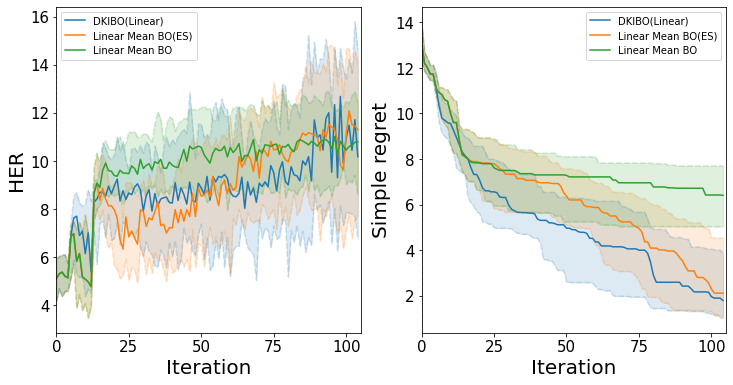

In [3]:
problem_name = 'photocatalysis_experiment'

base_path = r'C:\Users\darkn\PycharmProjects\DKIBO'

result_dfs = [
    pd.read_csv(os.path.join(base_path, 'experiment_results\\LinearBO_result_test_photocatalysis_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(base_path, 'experiment_new_ablation\\LinearMeanBO_result_test_photocatalysis_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(base_path, 'experiment_new_ablation\\LinearMeanBO_result_test_photocatalysis_experiment_no_ES.csv'), index_col=0),
]

model_list = [
    'DKIBO(Linear)',
    'Linear Mean BO(ES)',
    'Linear Mean BO'
]
        
show_pic(result_dfs, name='HER')

# New Experiment: Data from GYM

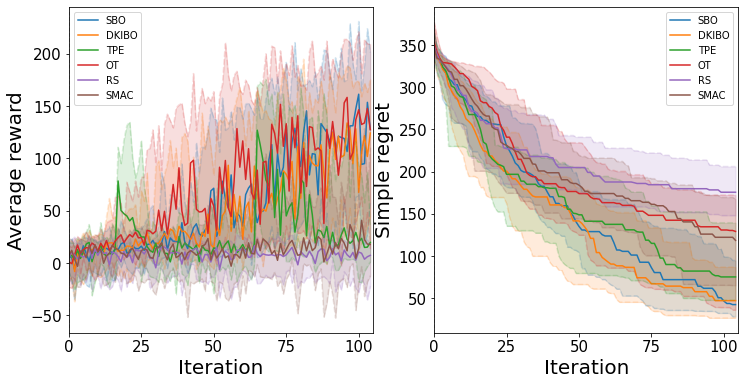

In [12]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results'

result_dfs = [
    pd.read_csv(os.path.join(PATH,'standardBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'RFBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'HyperoptOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'OpentunerOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'RandomOptimizer_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH,'ScikitOptimizer_result_test_swimmer_experiment.csv'), index_col=0)
]

model_list = [
    'SBO',
    'DKIBO',
    'TPE',
    'OT',
    'RS',
    'SMAC'
]

show_pic(result_dfs, name='Average reward')

In [7]:
get_result_dicts(result_dfs, model_list)

[{'name': 'DKIBO(RF)',
  'mean_value_deviation': 23.092263020219796,
  'CMR': 142.81465479747897,
  'CMR_deviation': 94.4514062638261,
  'median_regret': 47.29207007815896,
  'median_regret_deviation': 60.53710278955622},
 {'name': 'Standard BO',
  'mean_value_deviation': 21.806046392856064,
  'CMR': 155.35891513667428,
  'CMR_deviation': 103.21222062582042,
  'median_regret': 42.62051212800867,
  'median_regret_deviation': 44.316945828285924},
 {'name': 'HyperoptOptimizer',
  'mean_value_deviation': 12.926301705800027,
  'CMR': 163.51155311856348,
  'CMR_deviation': 88.91506217278061,
  'median_regret': 75.38135446981607,
  'median_regret_deviation': 55.048937536394},
 {'name': 'OpentunerOptimizer',
  'mean_value_deviation': 35.83224789046845,
  'CMR': 191.33285456109206,
  'CMR_deviation': 107.92607493621044,
  'median_regret': 129.26415530693004,
  'median_regret_deviation': 79.13806076129272},
 {'name': 'RandomOptimizer',
  'mean_value_deviation': 4.97527227388723,
  'CMR': 218.622

# Ablation 2: DKIBO ablation for photocatalysis

[{'name': 'DKIBO (k=2.6)',
  'mean_value_deviation': 0.8740695703806196,
  'CMR': 5.948351018769401,
  'CMR_deviation': 3.5792637947550223,
  'median_regret': 2.3282928466796875,
  'median_regret_deviation': 2.1462781854125983},
 {'name': 'Standard BO (k=2.6)',
  'mean_value_deviation': 0.6435214641434807,
  'CMR': 8.133793926239013,
  'CMR_deviation': 5.121673951042087,
  'median_regret': 3.1029186248779297,
  'median_regret_deviation': 2.6223117331805086},
 {'name': 'DKIBO (k=5.1)',
  'mean_value_deviation': 1.7845189088076636,
  'CMR': 6.244645239057995,
  'CMR_deviation': 3.330212534165088,
  'median_regret': 3.754263401031494,
  'median_regret_deviation': 3.0887958911541085},
 {'name': 'Standard BO (k=5.1)',
  'mean_value_deviation': 0.4770463012286595,
  'CMR': 9.09416355405535,
  'CMR_deviation': 4.569023825359619,
  'median_regret': 5.478947639465332,
  'median_regret_deviation': 2.603704725432855},
 {'name': 'DKIBO (k=1.3)',
  'mean_value_deviation': 1.4458865198535011,
  'CMR

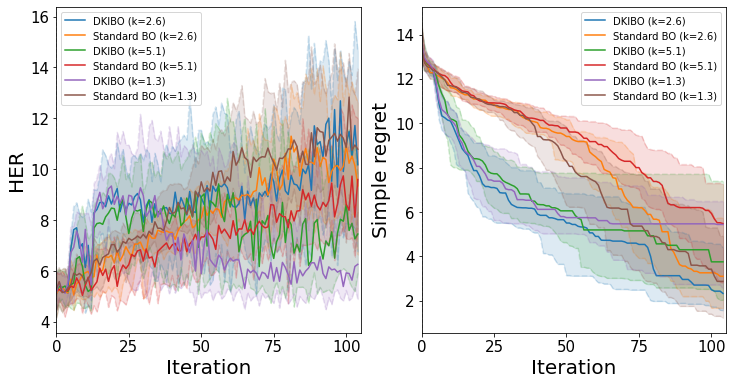

In [5]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO'

result_dfs = [
    pd.read_csv(os.path.join(PATH, 'experiment_results\\LinearBO_result_test_photocatalysis_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results\\standardBO_result_test_photocatalysis_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\LinearBO_result_test_photocatalysis_experiment_5.152.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\standardBO_result_test_photocatalysis_experiment_5.152.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\LinearBO_result_test_photocatalysis_experiment_1.288.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\standardBO_result_test_photocatalysis_experiment_1.288.csv'), index_col=0)
]

model_list = [
    'DKIBO (k=2.6)',
    'Standard BO (k=2.6)',
    'DKIBO (k=5.1)',
    'Standard BO (k=5.1)',
    'DKIBO (k=1.3)',
    'Standard BO (k=1.3)',
]

show_pic(result_dfs, name='HER')

get_result_dicts(result_dfs, model_list)

# Ablation 3: Gym swimmer ablation

[{'name': 'DKIBO (k=2.6)',
  'mean_value_deviation': 23.092263020219796,
  'CMR': 143.20007638495417,
  'CMR_deviation': 94.451406263826,
  'median_regret': 47.67749166563428,
  'median_regret_deviation': 60.53710278955622},
 {'name': 'DKIBO (k=2.6) GBRT',
  'mean_value_deviation': 14.98756959378445,
  'CMR': 147.06523895042525,
  'CMR_deviation': 92.30553344252303,
  'median_regret': 63.65466742903649,
  'median_regret_deviation': 50.66092316778682},
 {'name': 'Standard BO (k=2.6)',
  'mean_value_deviation': 21.806046392856064,
  'CMR': 155.7443367241495,
  'CMR_deviation': 103.21222062582032,
  'median_regret': 43.00593371548399,
  'median_regret_deviation': 44.316945828285924},
 {'name': 'DKIBO (k=5.1)',
  'mean_value_deviation': 13.696873758296888,
  'CMR': 169.39502016547482,
  'CMR_deviation': 94.16061785608954,
  'median_regret': 77.08723381556987,
  'median_regret_deviation': 44.32005152707116},
 {'name': 'DKIBO (k=5.1) GBRT',
  'mean_value_deviation': 13.388606823791427,
  'CM

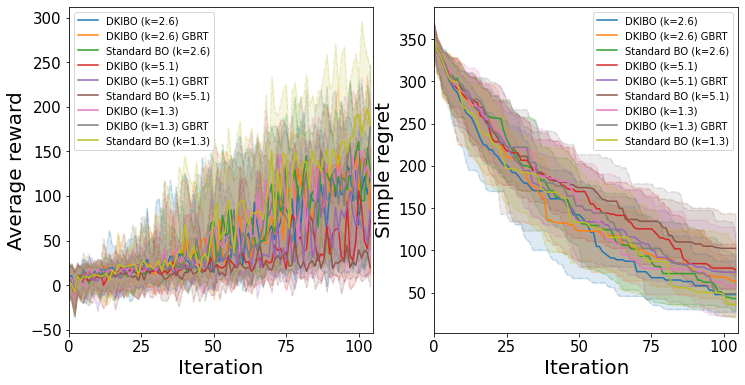

In [11]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO'

result_dfs = [
    pd.read_csv(os.path.join(PATH, 'experiment_results\\RFBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\GBRT_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results\\standardBO_result_test_swimmer_experiment.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\RFBO_result_test_swimmer_experiment_5.152.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\GBRT_result_test_swimmer_experiment_5.152.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\standardBO_result_test_swimmer_experiment_5.152.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\RFBO_result_test_swimmer_experiment_1.288.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\GBRT_result_test_swimmer_experiment_1.288.csv'), index_col=0),
    pd.read_csv(os.path.join(PATH, 'experiment_results_for_bo_variants\\standardBO_result_test_swimmer_experiment_1.288.csv'), index_col=0)
]

model_list = [
    'DKIBO (k=2.6)',
    'DKIBO (k=2.6) GBRT',
    'Standard BO (k=2.6)',
    'DKIBO (k=5.1)',
    'DKIBO (k=5.1) GBRT',
    'Standard BO (k=5.1)',
    'DKIBO (k=1.3)',
    'DKIBO (k=1.3) GBRT',
    'Standard BO (k=1.3)',
]


show_pic(result_dfs, name='Average reward')

get_result_dicts(result_dfs, model_list)

# Synthetic function ablations

In [8]:
PATH = r'C:\Users\darkn\PycharmProjects\DKIBO\experiment_results_for_bo_variants\result_collection'
ucbs = [1.288, 2.576, 5.152]


def get_result(ucbs):
    for ucb in ucbs:
        test_problems = [
            'Colville',
            'Michalewicz10',
            'Ackley',
            'Branin',
            'Eggholder',
            'GoldsteinPrice',
            'Hartmann6',
            'Rosenbrock',
            'SixHumpCamel',
            'StyblinskiTang'
        ]
        model_list = ['GBRT', 'RFBO', 'standardBO']
        folder = os.path.join(PATH, 'ucb_{}'.format(ucb))

        for prob in test_problems:
            print(prob)
            result_dfs = [pd.read_csv(os.path.join(folder, '{}_result_test_{}_{}.csv'.format(model, prob, ucb)), index_col=0) for model in model_list]
            print(get_result_dicts(result_dfs, model_list))

get_result(ucbs)

Colville
[{'name': 'GBRT', 'mean_value_deviation': 7210.760779018037, 'CMR': 2803.9142270289813, 'CMR_deviation': 2714.1553583735235, 'median_regret': 24.909983633299845, 'median_regret_deviation': 269.97603289826105}, {'name': 'RFBO', 'mean_value_deviation': 6411.940981346498, 'CMR': 2812.466574459897, 'CMR_deviation': 2675.6136371785524, 'median_regret': 31.00017586407094, 'median_regret_deviation': 344.6562783118723}, {'name': 'standardBO', 'mean_value_deviation': 9688.7322266683, 'CMR': 2952.1129199970246, 'CMR_deviation': 2923.030791074666, 'median_regret': 24.522194508216444, 'median_regret_deviation': 20.580370908787614}]
Michalewicz10
[{'name': 'GBRT', 'mean_value_deviation': 0.1799673988755853, 'CMR': 2.84897975801304, 'CMR_deviation': 1.0283689616273088, 'median_regret': 2.051967025028322, 'median_regret_deviation': 0.5872739458387146}, {'name': 'RFBO', 'mean_value_deviation': 0.1920748534925933, 'CMR': 2.844194850886766, 'CMR_deviation': 0.9713672297258686, 'median_regret': 

[{'name': 'GBRT', 'mean_value_deviation': 1.1798682187336231, 'CMR': 1.232316965728631, 'CMR_deviation': 1.2322063150007485, 'median_regret': 7.853342845023925e-05, 'median_regret_deviation': 0.00012574853407217233}, {'name': 'RFBO', 'mean_value_deviation': 1.2173387613247244, 'CMR': 1.4211696064394046, 'CMR_deviation': 1.4210430587854945, 'median_regret': 6.737335619275142e-05, 'median_regret_deviation': 0.0001492747963887103}, {'name': 'standardBO', 'mean_value_deviation': 1.0924806451504414, 'CMR': 1.3263026316161355, 'CMR_deviation': 1.326196272303818, 'median_regret': 6.634543190564557e-05, 'median_regret_deviation': 0.00011688363463263662}]
Eggholder
[{'name': 'GBRT', 'mean_value_deviation': 74.98971005109209, 'CMR': 69.84592172830739, 'CMR_deviation': 67.09550721842817, 'median_regret': 1.236752744264777, 'median_regret_deviation': 4.613798722382363}, {'name': 'RFBO', 'mean_value_deviation': 72.42904996675274, 'CMR': 73.57327058195362, 'CMR_deviation': 71.21579160574069, 'median

[{'name': 'GBRT', 'mean_value_deviation': 0.1288610447391357, 'CMR': 0.9941209235893008, 'CMR_deviation': 0.8939430403843067, 'median_regret': 0.07563651762514167, 'median_regret_deviation': 0.10713242755309375}, {'name': 'RFBO', 'mean_value_deviation': 0.15421042705176977, 'CMR': 1.011934061441449, 'CMR_deviation': 0.7269348813010188, 'median_regret': 0.24351801403517181, 'median_regret_deviation': 0.25939453912292965}, {'name': 'standardBO', 'mean_value_deviation': 0.044427645426616896, 'CMR': 1.4470347597557578, 'CMR_deviation': 0.9144220664093641, 'median_regret': 0.5167941759345354, 'median_regret_deviation': 0.2872659264805463}]
Rosenbrock
[{'name': 'GBRT', 'mean_value_deviation': 4730.165863539518, 'CMR': 252.54078910294848, 'CMR_deviation': 252.2456490544339, 'median_regret': 0.16221496393419024, 'median_regret_deviation': 0.3637501898371619}, {'name': 'RFBO', 'mean_value_deviation': 5287.5816348717335, 'CMR': 433.7800902158807, 'CMR_deviation': 433.28398094035276, 'median_regr